In [1]:
import random 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from initialize_world import create_sorting_world, create_oil_world
from utils import update_canvass, _draw, _summarize

In [2]:
def take_first(elem):
    return elem[0]


def _seek(loc):
    """returns a randomly selected valid move from loc.
    
    a loc is valid if it's in the board and an unoccupied slot.
    """
    i = loc[0]
    j = loc[1]
    
    # step 1 - make sure it's on the board
    new_locs = [(min(i + 1, N_ROWS - 1), j), 
                (max(i - 1, 0), j), 
                (i, min(j + 1, N_COLS - 1)), 
                (i, max(j - 1, 0))]
    
    # step 2 - make sure the next loc is not occupied
    new_locs = [loc for loc in new_locs if loc not in WORLD.keys()]
    
    # step 3 - if there are no unoccupied slots, then stay put
    if new_locs:
        return random.choice(new_locs)
    return loc

            
def _move(curr_loc, next_loc, element):
    """move element from curr_loc to next_loc.
    """
    if next_loc != curr_loc:
        WORLD[next_loc] = element
        WORLD.pop(curr_loc)
        return True
    return False


def _return_neighboring_locs(curr_loc, dist):
    """return neighboring locs, occupied or unoccupied
    """
    i = curr_loc[0]
    j = curr_loc[1]
    neighboring_locs = [(min(i + dist, N_ROWS - dist), j), 
                        (max(i - dist, 0), j), 
                        (i, min(j + dist, N_COLS - dist)), 
                        (i, max(j - dist, 0))]
    # check that neighbor is not itself
    neighboring_locs = [loc for loc in neighboring_locs if loc != curr_loc]
    
    return neighboring_locs


def _sample():
    """draw a sample to populate sorters and emitters.
    """
    return np.random.randint(0, 100)

def _return_neighboring_occupied_locs(curr_loc):
    """return all locs that are occupied.
    """
    neighboring_locs = _return_neighboring_locs(curr_loc, 1)
    return [loc for loc in neighboring_locs if loc in WORLD.keys()]

In [3]:
def update_dreg(curr_loc):
    
    # do something to a neighbor slot
    next_loc = _seek(curr_loc)
    
    if _draw(.30):  # create res with 30% chance
        WORLD[next_loc] = (2, None)
    elif _draw(.01):  # or create a new dreg with 1% chance
        WORLD[next_loc] = (1, None)
    else:
        pass
    
    # if dreg is next to a occupied slot, randomly destroy neighborhood
    if _draw(.01):
        neighbors = _return_neighboring_occupied_locs(curr_loc)
        # print("curr is ", curr_loc, "with neighbors", neighbors)
        if neighbors:
            for loc in neighbors:
                # print("popping", loc)
                WORLD.pop(loc)

    # move to an unoccupied slot (or stay put if there are no unoccupied slots)
    e = (1, None)
    next_loc = _seek(curr_loc)
    # print("curr loc is", curr_loc, curr_loc in WORLD.keys())
    _ = _move(curr_loc, next_loc, e)

    
def update_res(curr_loc):
    
    if np.random.uniform() < .3:
        WORLD.pop(curr_loc)
    else:
        # move res to an unoccupied slot (or stay put if there are no unoccupied slots)
        e = (2, None)
        next_loc = _seek(curr_loc)
        _ = _move(curr_loc, next_loc, e)
        

def update_data(curr_loc):
    if _draw(.20):
        e = (4, WORLD[curr_loc][1])
        next_loc = _seek(curr_loc)
        _ = _move(curr_loc, next_loc, e)
    

def update_emitter(curr_loc):
    """
    emitter has an id of 5
    
    1) emit data in a neighboring free spot 
    2) then reproduce itself if there is a res, 
    3) no moving so it stays where it was created.
    """

    # step 1 - if a neighbor is a res... turn it into (a) data or (b) Emitter
    
    neighboring_locs = _return_neighboring_occupied_locs(curr_loc)
    if neighboring_locs:
        for neighbor in neighboring_locs:
            if WORLD[neighbor][0] == 2:
                if _draw(.90):
                    WORLD[neighbor] = (4, _sample())
                else:
                    WORLD[neighbor] = (5, None)
                                
                
def update_sorter(curr_loc):
    """
    In  this  version, Sorter has two primary functions. 
    
    First, whenever it sees a Res, it transmutes it into another Sorter, and so 
    the Sorter population  level  is indirectly  controlled  by DReg.
    
    Secondly, Sorter transports Datums from right to left when possible, and also up 
    or down based on the comparison of the Datum’s value with a 32-bit threshold stored 
    in the Sorter. 
    
    When a Datum ‘crosses’ the Sorter during  a  move,  the Sorter copies  the Datum’s  
    value  to  its  threshold
    """
    right_loc = (curr_loc[0], curr_loc[1] + 1)
    
    # step 1 - move data... if theres something to its right
    if right_loc in WORLD.keys():
        neighbor = WORLD[right_loc]
        
        # we only want data elements...
        if neighbor[0] == 4:
            dist = 2
            
            # move it if data is greater
            if neighbor[1] > WORLD[curr_loc][1]:
                
                # move data up and the left

                next_loc = (curr_loc[0] - dist, curr_loc[1] - dist)
                WORLD[next_loc] = (4, neighbor[1])
                WORLD.pop(right_loc)
                
                # sorter update its internal value
                WORLD[curr_loc] = (3, neighbor[1])
            
            # if not... move data down and left
            else:
                next_loc = (curr_loc[0] + dist, curr_loc[1] - dist)
                WORLD[next_loc] = (4, neighbor[1])
                WORLD.pop(right_loc)

                
                
    # step 2 - convert all neighboring res into Sorters
    neighbors = _return_neighboring_occupied_locs(curr_loc)
    if neighbors:
        for neighbor in neighbors:
            if WORLD[neighbor][0] == 2:
                WORLD[neighbor] = (3, _sample())
    
    
    # step 3 - move if one of its neighbors is a Sorter
    neighbors = _return_neighboring_occupied_locs(curr_loc)
    if neighbors:
        for neighbor in neighbors:
            if WORLD[neighbor][0] == 3:
                next_loc = _seek(curr_loc)
                e = (3, WORLD[curr_loc][1])
                _ = _move(curr_loc, next_loc, e)
                break
                
    # step 4 - die if it's surrounded by too many sorters
    count = 0
    neighbors = _return_neighboring_occupied_locs(curr_loc)
    if neighbors:
        for neighbor in neighbors:
            if WORLD[neighbor][0] == 3:
                count += 1
    if count > 3:
        WORLD.pop(next_loc)  # it is a next_loc because it moved in step 3

In [4]:
def _blob(curr_loc):

    stack = [curr_loc]
    visited = []

    while stack:
        curr = stack.pop()
        visited.append(curr)

        search_grid = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (j == 0) and (i == 0):
                    pass
                else:
                    search_grid.append((curr[0] + i, curr[1] + j))

        for grid in search_grid:
            if grid in WORLD.keys() and (grid not in visited) and (grid not in stack):
                if WORLD[grid][0] == 6:
                    stack.append(grid)
    return sorted(visited, key = lambda x: x[0])

In [5]:
def update_oil(curr_loc):
    # step 1 - convert all neighboring res into oil
    neighbors = _return_neighboring_occupied_locs(curr_loc)
    if neighbors:
        for neighbor in neighbors:
            if WORLD[neighbor][0] == 2:
                WORLD[neighbor] = (6, None)
    
    # move if it's not surrounded by enough oil droplets
    count = 0
    neighbors = _return_neighboring_occupied_locs(curr_loc)
    if neighbors:
        for neighbor in neighbors:
            if WORLD[neighbor][0] == 6:  # 6 is oil's id
                count += 1
    
    
    if (count < 3):
        blob = _blob(curr_loc)
        offset = random.choice([-1, 0, 1])
        e = (6, None)
        for b in blob:
            _ = _move(b, (b[0] + offset, b[1] + offset), e)


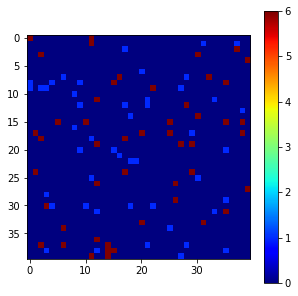

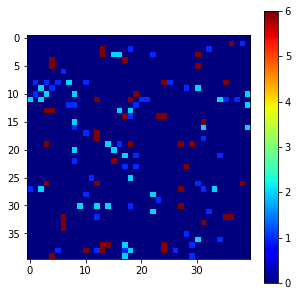

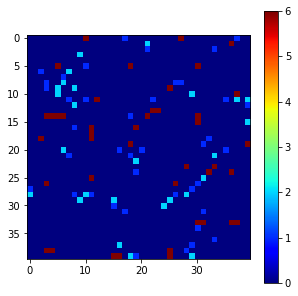

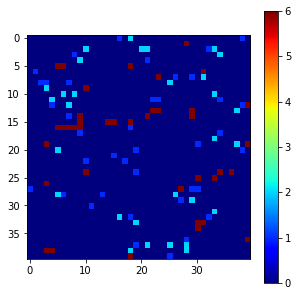

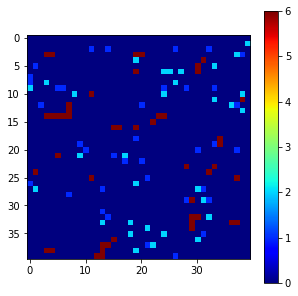

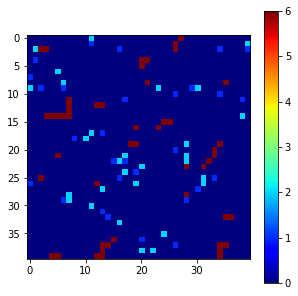

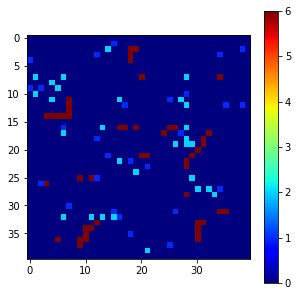

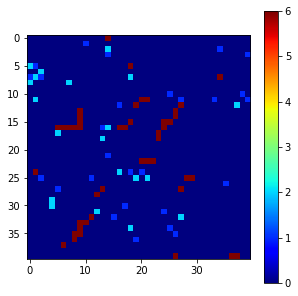

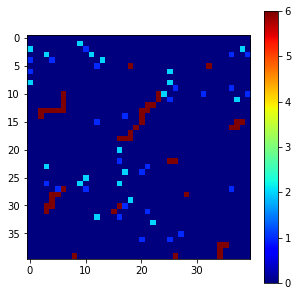

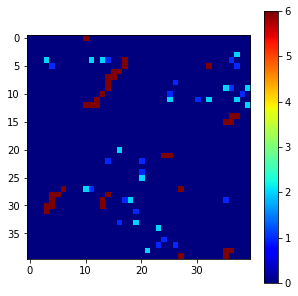

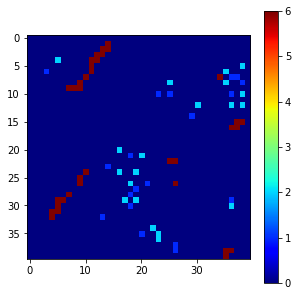

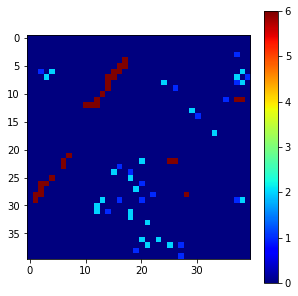

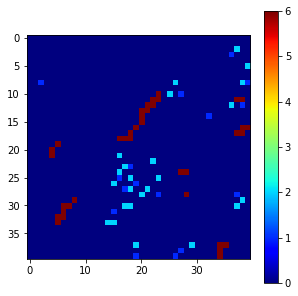

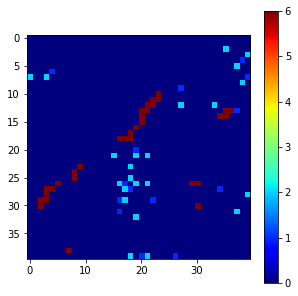

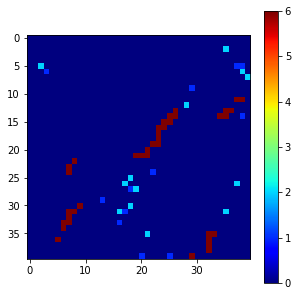

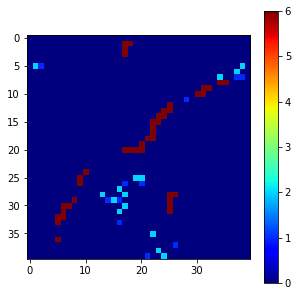

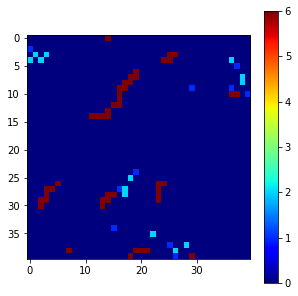

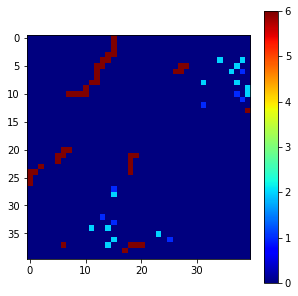

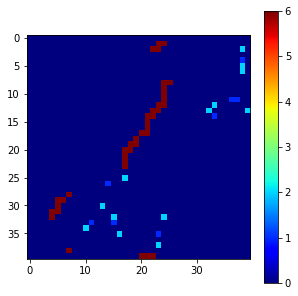

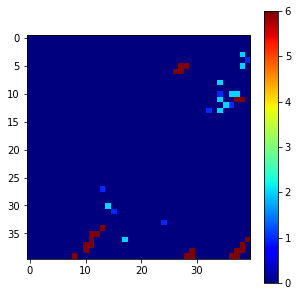

In [6]:
loop = {1: update_dreg, 
        2: update_res, 
        3: update_sorter, 
        4: update_data, 
        5: update_emitter, 
        6: update_oil}

N_ROWS = 40
N_COLS = 40
epochs = 10000

WORLD = create_oil_world(n_rows=N_ROWS, n_cols=N_COLS, n_dregs=50, n_oil=50)
CANVASS = np.zeros((N_ROWS, N_COLS))

for epoch in range(epochs):        

    # select a random element to update
    loc = random.choice(list(WORLD.keys()))
    element = WORLD[loc]

    element_id = element[0]

    # fetch and execute
    loop[element_id](loc)


    if epoch % (epochs / 20) == 0:
        CANVASS = update_canvass(canvass=CANVASS, env=WORLD, n_rows=N_ROWS, n_cols=N_COLS)
        plt.figure(figsize=(5,5))
        plt.imshow(CANVASS, cmap='jet')
        plt.colorbar(cmap='jet')

        # fname = "gif/test_" + str(epoch)
        # plt.savefig(fname)
        # plt.clf()
        
# _summarize(WORLD)

In [7]:
# we want data elements on the left side of the board

keep = []
for k in WORLD.keys():
    if k[1] < 20 and WORLD[k][0] == 4:
        keep.append(k)
# keep

In [8]:
sorted_list = sorted(keep, key=take_first)

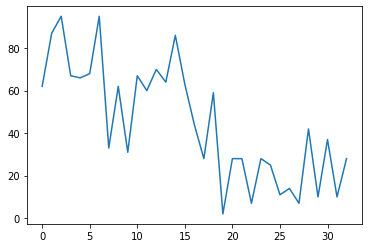

In [9]:
# shuld be descending order
ans = []
for i in sorted_list:
    ans.append(WORLD[i][1])
    
plt.plot(ans)

In [10]:
# https://ezgif.com/